## SpaRED Library Quick Start DEMO

This demonstration is a step by step on how to use the SpaRED library to train a gene expression prediction model with pre-trained weights. In this tutorial we will illustrate how to:

* Load a SpaRED dataset and save it in an AnnData object.
* Prepare the data for training a pretrained model for gene expression prediction.
* Initialize a pretrained model.
* Train the model using pytorch lightning.

In [2]:
import os
import sys
from pathlib import Path
import pathlib

currentdir = os.getcwd()
parentdir = str(Path(currentdir).parent)
sys.path.append(parentdir)
print(parentdir)

import spared

/media/SSD4/dvegaa/SpaRED/spared


### Load Datasets

The `datasets` file has a function to get any desired dataset and return the adata as well as the parameter dictionary. This function returns a filtered and processed adata. This function has a parameter called *visualize* that allows for all visualizations if set to True. The fuction also saves the raw_adata (not processed) in case it is required. 

We will begin by loading a dataset and setting the *visualize* parameter as False since no images are required for the functions analized in this DEMO.

In [3]:
from spared.datasets import get_dataset

#get dataset
data = get_dataset("vicari_mouse_brain", visualize=False)

/home/dvegaa/anaconda3/envs/H2ST/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading vicari_mouse_brain dataset with the following data split:
train data: ['V11L12-038_A1', 'V11L12-038_B1', 'V11L12-038_C1', 'V11L12-038_D1', 'V11L12-109_A1', 'V11L12-109_B1', 'V11L12-109_C1', 'V11L12-109_D1']
val data: ['V11T16-085_A1', 'V11T16-085_B1', 'V11T16-085_C1', 'V11T16-085_D1']
test data: ['V11T17-101_A1', 'V11T17-101_B1']
Parameters already saved in /media/SSD4/dvegaa/SpaRED/spared/spared/processed_data/vicari_data/vicari_mouse_brain/2024-08-11-18-40-39/parameters.json
Loading main adata file from disk (/media/SSD4/dvegaa/SpaRED/spared/tutorials/processed_data/vicari_data/vicari_mouse_brain/2024-08-11-18-40-39/adata.h5ad)...
The loaded adata object looks like this:
AnnData object with n_obs × n_vars = 43804 × 128
    obs: 'in_tissue', 'array_row', 'array_col', 'patient', 'slide_id', 'split', 'unique_id', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'exp_frac', 'glob_exp_frac', 'n_cells_by_counts', 'mean_counts', 'pct

### Prepare data

To train a pretrained model for gene expression prediction, we must first prepare the data. This involves using Dataloaders, a component commonly used in machine learning frameworks like PyTorch to handle the loading of data in an efficient and flexible manner. The function `get_pretrain_dataloaders` receives the following parameters as input:

* **adata (ad.AnnData):** AnnData object to process.
* **layer (str):** The layer to use for pre-training. Default is set to `c_t_log1p`.
* **batch_size (int):** The batch size of the loaders. Default is set to 128.
* **shuffle (bool):** Whether to shuffle the data in the loaders. Default is set to True.
* **cuda (bool):** Whether to use CUDA in the loaders. Default is set to False.

##### <u>Returns:</u>

This function returns train, validation, and test dataloaders as a tuple to be used for training a pretrained model.


In [4]:
from spared.dataloaders import get_pretrain_dataloaders

# Declare train and test loaders
train_dataloader, val_dataloader, test_dataloader = get_pretrain_dataloaders(
    adata=data.adata,
    layer = 'c_t_log1p',
    batch_size = 265,
    shuffle = True,
    use_cuda = True
)

Percentage of imputed observations with transformer model: 27.503%


### Initialize model

The SpaRED library provides a function to  initilize a model with pretrained weights for gene expression prediction. The function `ImageBackbone` class receives the following inputs:

* **args (argparse):** Argument parser with specific variables required to initialize the model.
* **latem_dim (int):** Latent dimensions used as output feature dimensions in the last layer of the defined model.

##### <u>Returns:</u>

The function returns the initialized model. The backbone used for pretrained weights is defined in the argparse parameters. In this demo, we will use ShuffleNetV2. You can check the available backbones in the documentation of the SpaRED library.

In [5]:
from spared.models import ImageBackbone
import argparse
import torch

# Define argparse variables
test_args = argparse.Namespace()
arg_dict = vars(test_args)
input_dict = {
    'img_backbone': 'ShuffleNetV2',
    'img_use_pretrained': True,
    'average_test': False,
    'optim_metric': 'MSE',
    'robust_loss': False,
    'optimizer': 'Adam',
    'lr': 0.0001,
    'momentum': 0.9,
}

for key,value in input_dict.items():
    arg_dict[key]= value


# Declare device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImageBackbone(args=test_args,  latent_dim=data.adata.n_vars).to(device)
model


ImageBackbone(
  (test_transforms): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (criterion): MSELoss()
  (encoder): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2

### Training the model

Now we will use PyTorch Lightning to train the model. First, we must define a `ModelCheckpoint` callback to monitor the validation mean squared error (val_MSE) and save only the best model based on this metric. Then, we initialize a `Trainer` and define various parameters. In this case our model will run for a maximum of 1000 training steps, perform validation every 10 steps, log progress every 10 steps, and use one GPU for training. Additionally, the trainer displays a progress bar and a model summary during training. This setup ensures efficient model training and validation, with automatic saving of the best model based on the specified validation metric.

In [6]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint

# Define checkpoint callback to save best model in validation
checkpoint_callback = ModelCheckpoint(
    monitor=f'val_MSE', # Choose your validation metric
    save_top_k=1, # Save only the best model
    mode='min'
)

# Define the trainier and fit the model
trainer = Trainer(
    max_steps=30,
    val_check_interval=10,
    log_every_n_steps=10,
    callbacks=[checkpoint_callback],
    check_val_every_n_epoch=None,
    devices=[6],
    enable_progress_bar=True,
    enable_model_summary=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Now, we must begin the training process using PyTorch Lightning's `Trainer` with the `fit` method. The `fit` method is called with the specified model, training data loader (train_dataloader), and validation data loader (val_dataloader). This setup allows the Trainer to manage the training loop, including feeding the model with training data, performing validation at specified intervals, and utilizing the previously defined configurations and callbacks for efficient training and model checkpointing.

In [7]:
trainer.fit(
    model=model,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name            | Type         | Params
-------------------------------------------------
0 | test_transforms | Normalize    | 0     
1 | criterion       | MSELoss      | 0     
2 | encoder         | ShuffleNetV2 | 472 K 
-------------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)


Epoch 0:  33%|███▎      | 30/90 [02:39<05:18,  0.19it/s, v_num=5]          

`Trainer.fit` stopped: `max_steps=30` reached.


Epoch 0:  33%|███▎      | 30/90 [02:39<05:18,  0.19it/s, v_num=5]


### Evaluate models performance

After training, the path to the best model is obtained from the `checkpoint_callback`. We can use the best model to evaluate performance on the test set (if available). We load the model from the `checkpoint_callback` path and use the `trainer.test` method to evaluate the model's performance on the test data. 

In [8]:
# Load the best model after training
best_model_path = checkpoint_callback.best_model_path
print(best_model_path)
model = ImageBackbone.load_from_checkpoint(best_model_path)

# Test model if there is a test dataloader
if not (test_dataloader is None):
    trainer.test(model, dataloaders=test_dataloader)

/media/SSD4/dvegaa/SpaRED/spared/tutorials/lightning_logs/version_5/checkpoints/epoch=0-step=30.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 26/26 [00:19<00:00,  1.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_Global          -240.42971801757812
        test_MAE             9.327844619750977
        test_MSE             90.31873321533203
      test_PCC-Gene        -0.07831642031669617
     test_PCC-Patch        0.020641593262553215
      test_R2-Gene          -110.23809814453125
      test_R2-Patch         -30.487369537353516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [9]:
print(best_model_path)

/media/SSD4/dvegaa/SpaRED/spared/tutorials/lightning_logs/version_5/checkpoints/epoch=0-step=30.ckpt


In [10]:
from tqdm import tqdm

def get_predictions(dataloader, model, device="cuda")->None:
    # Set model to eval mode
    model=model.to(device)
    model.eval()

    glob_expression_pred = None
    # Get complete predictions
    with torch.no_grad():
        for b in tqdm(range(0,len(test_dataloader.dataset))):
            batch = dataloader.dataset[b]
            expression_pred, expression_gt, mask = model.test_step(batch)
            expression_pred = expression_pred.cpu()

            # Concat batch to get global predictions and IDs
            glob_expression_pred = expression_pred if glob_expression_pred is None else torch.cat((glob_expression_pred, expression_pred))

    return glob_expression_pred



In [11]:
# Put complete predictions in a single dataframe
glob_expression_pred = get_predictions(test_dataloader, model)

  0%|          | 0/6730 [00:00<?, ?it/s]

100%|██████████| 6730/6730 [49:06<00:00,  2.28it/s]  


In [12]:
glob_expression_pred.shape

torch.Size([6730, 128])

In [13]:
import pandas as pd  
        
# Put complete predictions in a single dataframe
adata_test = data.adata[data.adata.obs["split"] == "test"]
pred_matrix = glob_expression_pred
glob_ids = adata_test.obs['unique_id'].tolist()
pred_df = pd.DataFrame(pred_matrix, index=glob_ids, columns=adata_test.var_names)
pred_df = pred_df.reindex(adata_test.obs.index)

# Add layer to adata
layer = "c_t_log1p"
adata_test.layers[f'predictions,{layer}'] = pred_df

In [14]:
adata_test

AnnData object with n_obs × n_vars = 6730 × 128
    obs: 'in_tissue', 'array_row', 'array_col', 'patient', 'slide_id', 'split', 'unique_id', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_symbol', 'exp_frac', 'glob_exp_frac', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_length', 'd_log1p_moran', 'log1p_avg_exp', 'd_log1p_avg_exp', 'c_log1p_avg_exp', 'c_d_log1p_avg_exp'
    uns: 'spatial', 'spatial_neighbors'
    obsm: 'patches_scale_1.0', 'spatial'
    layers: 'c_d_deltas', 'c_d_log1p', 'c_deltas', 'c_log1p', 'c_t_deltas', 'c_t_log1p', 'counts', 'd_deltas', 'd_log1p', 'deltas', 'log1p', 'mask', 'tpm', 'noisy', 'predictions,c_t_log1p'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [15]:
os.makedirs('./prediction_images', exist_ok=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

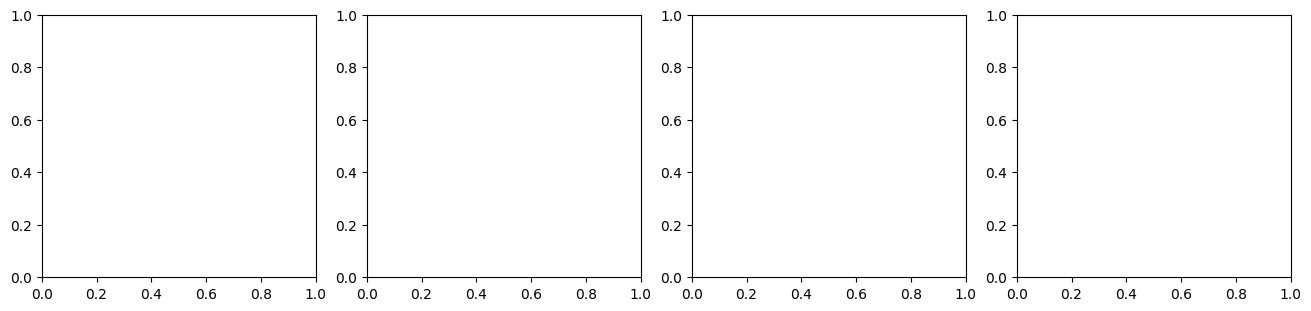

In [16]:
from spared.plotting import log_pred_image
log_pred_image(adata_test, n_genes=2, slides={}, save_path='./prediction_images')